In [6]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
import numpy as np
from sklearn.metrics import roc_curve, auc, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
data = pd.read_csv("./data/prevalence_sentence_sim_annotated_v2.csv", names=["sent1", "sent2", "score", "label"])
# drop rows where label is nan
data.dropna(subset=["label"], inplace=True)
data["label"] = data["label"].map({"yes": True, "no": False})
# data.drop(columns=["score"], inplace=True)
# reindex the dataframe
data.reset_index(drop=True, inplace=True)
data["label"].value_counts()

label
True     340
False    276
Name: count, dtype: int64

/home/koen/tmp/ipykernel_20647/2886095281.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  label_data = data.groupby(pd.cut(data["score"], bins=[0.5, 0.6, 0.7, 0.8, .9, 1.]))["label"].value_counts().unstack().fillna(0)


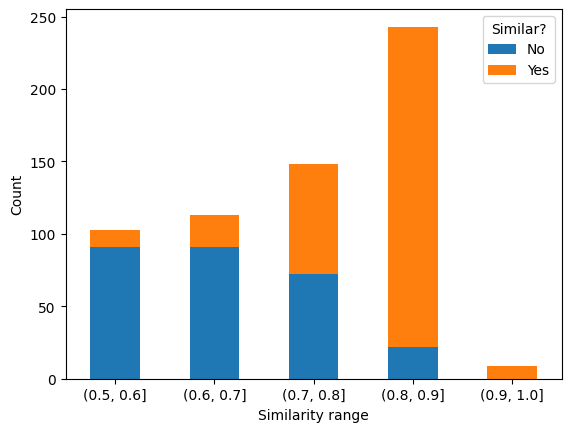

In [13]:
label_data = data.groupby(pd.cut(data["score"], bins=[0.5, 0.6, 0.7, 0.8, .9, 1.]))["label"].value_counts().unstack().fillna(0)
ax = label_data.plot.bar(stacked=True, rot=0, xlabel="Similarity range", ylabel="Count")
ax.legend(["No", "Yes"], title="Similar?")

In [4]:
model_names = [
    ("bert-base-multilingual-cased", "bert-base-multilingual-cased"),
    ("./models/bert-base-multilingual-cased-finetuned-full", "bert-base-multilingual-cased (finetuned)"),
    ("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2", "paraphrase-multilingual-MiniLM-L12-v2"),
    ("sentence-transformers/paraphrase-multilingual-mpnet-base-v2", "paraphrase-multilingual-mpnet-base-v2"),
    ("sentence-transformers/distiluse-base-multilingual-cased-v1", "distiluse-base-multilingual-cased-v1"),
    ("./models/training_nli_v2_models-bert-base-multilingual-cased-finetuned-full-2022-11-18_10-37-48/", "bert-base-multilingual-cased (MedNLI finetuned)"),
    ("./models/training_nli_v2_sentence-transformers-distiluse-base-multilingual-cased-v1-2023-02-03_14-15-33/", "distiluse-base-multilingual-cased-v1 (MedNLI finetuned)"),
]
result_dict = {}
for name in tqdm(model_names, desc="Running predictions..."):
    model = SentenceTransformer(name[0])
    def get_score(row):
        sent1 = model.encode(row.sent1, convert_to_tensor=True)
        sent2 = model.encode(row.sent2, convert_to_tensor=True)
        return np.clip(cos_sim(sent1, sent2).item(), 0, 1)
    result_dict[name[1]] = {"score": data.apply(get_score, axis=1)}


No sentence-transformers model found with name /home/koen/.cache/torch/sentence_transformers/bert-base-multilingual-cased. Creating a new one with MEAN pooling.
Running predictions...:  14%|█▍        | 1/7 [00:44<04:25, 44.18s/it]No sentence-transformers model found with name ./models/bert-base-multilingual-cased-finetuned-full. Creating a new one with MEAN pooling.
Some weights of BertModel were not initialized from the model checkpoint at ./models/bert-base-multilingual-cased-finetuned-full and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Running predictions...: 100%|██████████| 7/7 [02:43<00:00, 23.42s/it]


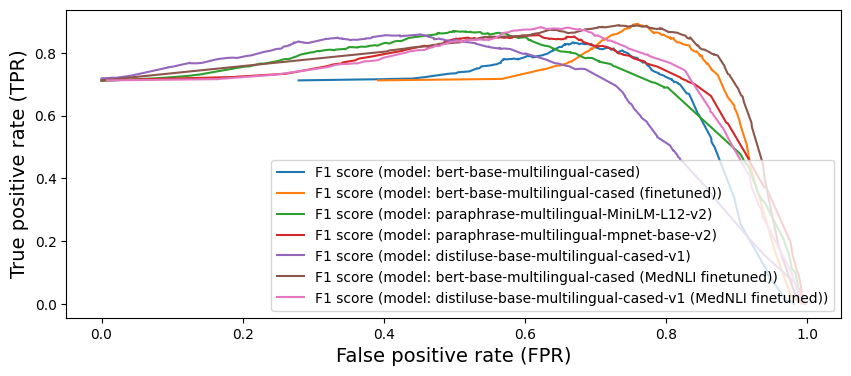

In [11]:
plt.figure(figsize=(10, 4))
for name, vals in result_dict.items():
    fpr, tpr, thresholds = roc_curve(data["label"], vals["score"], pos_label=1)
    auc_score = auc(fpr, tpr)
    f1 = [f1_score(data["label"], vals["score"] > t, pos_label=1) for t in thresholds]
    # plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f} (model: {name})")
    plt.plot(thresholds, f1, label=f"F1 score (model: {name})")
plt.xlabel("False positive rate (FPR)", fontsize=14)
plt.ylabel("True positive rate (TPR)", fontsize=14)
plt.legend(loc="lower right", alignment="center")
# plt.title("ROC curves for sentence similarity models")
plt.show()